# Rounded squares

This example demonstrates how to perform simulations of rounded squares using the DEM component of HOOMD.

## Initialize

Import the hoomd python package, the md and dem components to execute DEM/MD simulations.

In [1]:
import hoomd
import hoomd.md
import hoomd.dem

Initialize the execution context to control where HOOMD will execute the simulation. When no command line options are provided, HOOMD will auto-select a GPU if it exists, or run on the CPU.

In [2]:
hoomd.context.initialize("");

HOOMD-blue v2.1.5 CUDA (7.5) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX 
Compiled: 03/09/2017
Copyright 2009-2016 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
-----
You are using DEM. Please cite the following:
* M Spellings, R L Marson, J A Anderson, and S C Glotzer. "GPU accelerated
  Discrete Element Method (DEM) molecular dynamics for conservative, faceted
  particle simulations",  Journal of Computational Physics 334 (2017) 460--467
-----
notice(2): This system is not compute exclusive, usi

Place the squares on an initial square lattice. HOOMD applies rotational equations of motion only in degrees of freedom that have non-zero moment of inertia. Give every particle a moment of inertia about the z-axis consistent with a uniform mass distribution on the square.

In [3]:
uc = hoomd.lattice.unitcell(N = 1,
                            a1 = [4,     0,   0],
                            a2 = [0,     4,   0],
                            a3 = [0,     0,   1],
                            dimensions = 2,
                            position = [[0,0,0]],
                            type_name = ['A'],
                            mass = [1.0],
                            moment_inertia = [[0,
                                               0,
                                               1/12]],
                            orientation = [[1, 0, 0, 0]]);

In [4]:
import numpy
snapshot = uc.get_snapshot()
snapshot.replicate(5,5,1)
snapshot.particles.velocity[:,0:2] = numpy.random.normal(0.0,
  numpy.sqrt(1.6 / 1.0), [snapshot.particles.N, 2]);

In [5]:
hoomd.init.read_snapshot(snapshot);

notice(2): Group "all" created containing 25 particles


## Define the potential energy

Apply the WCA potential energy between vertices and edges of the squares. 

Choose the neighbor list acceleration structure to find neighboring particles efficiently. In systems with only one cutoff length, the cell method performs best.

In [6]:
nl = hoomd.md.nlist.cell()

Each particle is an extended body defined by vertices, edges, and faces. The DEM component applies pair potentials between particles that results in both forces and torques on the particles.

Here, we define the geometry of a perfect square with side length 2 in the particle coordinate system. The WCA potential is applied between edges, vertices, and faces with $\sigma = 2\cdot r$ and has the effect of rounding the square with radius $r$.

In [7]:
squares = hoomd.dem.pair.WCA(radius=.1, nlist=nl)
square_verts = [[1, 1], [-1, 1], [-1, -1], [1, -1]]
squares.setParams('A', vertices=square_verts)

## Select integrator

The integrator defines the equations of motion that govern the system of particles, given the current configuration of the particles and the net force from all potentials. The standard integration mode in HOOMD allows different integrators to apply to different groups of particles with the same step size $dt$.

In [8]:
hoomd.md.integrate.mode_standard(dt=0.001);

Apply constant energy Newtonian equations of motion to all particles. Unless otherwise documented, HOOMD integrators apply to both translational and rotational degrees of freedom.

In [9]:
all = hoomd.group.all()
hoomd.md.integrate.nve(group=all);

## Write output

Periodically log the potential energy of the system to a text file.

In [10]:
hoomd.analyze.log(filename="log-output.log",
                  quantities=['potential_energy',
                              'translational_kinetic_energy',
                              'rotational_kinetic_energy'],
                  period=10,
                  overwrite=True);

Periodically write the particle configurations to a gsd file.

In [11]:
hoomd.dump.gsd("trajectory.gsd",
               period=100,
               group=hoomd.group.all(),
               overwrite=True);     

## Run the simulation

Move the simulation forward in time.

In [12]:
hoomd.run(20*100);

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 25
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:00 | Step 2000 / 2000 | TPS 6607.01 | ETA 00:00:00
Average TPS: 6402.52
---------
-- Neighborlist stats:
26 normal updates / 8 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 4 / n_neigh_avg: 1.84
shortest rebuild period: 65
-- Cell list stats:
Dimension: 5, 5, 1
n_min    : 0 / n_max: 2 / n_avg: 1
** run complete **


## Examine the output

Use matplotlib to plot the potential energy vs time step.

In [13]:
import numpy
from matplotlib import pyplot
%matplotlib inline
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);

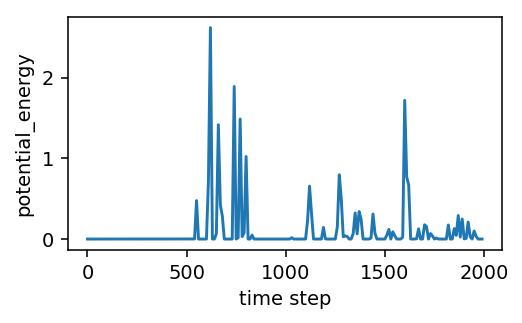

In [14]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,1]);
pyplot.xlabel('time step');
pyplot.ylabel('potential_energy');

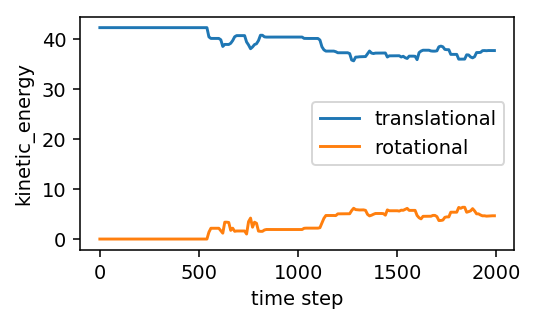

In [17]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,2]);
pyplot.plot(data[:,0], data[:,3]);
pyplot.xlabel('time step');
pyplot.ylabel('kinetic_energy');
pyplot.legend(['translational', 'rotational'], loc='center right');

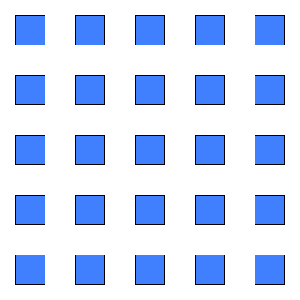

In [16]:
import ex_render
ex_render.display_movie(lambda x: ex_render.render_polygon_frame(x, square_verts), 'trajectory.gsd');